**CMB emulator training tutorial-compressed way**\
This tutorial goes through how to train an emulator for CMB power spectrum. This tutorial, different from the other tutorial for training, compress the codes of defining models and training process in a package called **emulator**. This one is intended to be more user-friendly, while the other one is intended more for people to understand the process of developing the code and can modify codes according to their own need. We use CMB TT power spectrum as the example here, and same strategies will apply to EE and TE. 

In [65]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import camb
import scipy.linalg
from camb import model, initialpower
from camb.dark_energy import DarkEnergyPPF, DarkEnergyFluid
import emulator
from emulator import Supact, Affine, Better_Attention, Better_Transformer, ResBlock, ResMLP, TRF, train

In [2]:
##### SET UP CMB POWER SPECTRA RANGE #####

camb_ell_min          = 2
camb_ell_max          = 2002
camb_ell_range        = camb_ell_max - camb_ell_min

##### PICK DEVICE ON WHICH THE MODEL WILL BE TRAINED ON. WE RECOMMEND USING GPU FOR TRAINING #####
device                = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#CUDA for GPU
#CPU for CPU
#GPU is generally recommended for higher speed.


In [3]:
##### LOAD UP MEAN AND STD FOR INPUT AND OUTPUT #####
extrainfo=np.load("Demo/extra_demo.npy",allow_pickle=True)
X_mean=torch.Tensor(extrainfo.item()['X_mean'])#.to(device)
X_std=torch.Tensor(extrainfo.item()['X_std'])#.to(device)
Y_mean=torch.Tensor(extrainfo.item()['Y_mean']).to(device)
Y_std=torch.Tensor(extrainfo.item()['Y_std']).to(device)

##### LOAD UP COV MAT #####
covinv=np.load('Demo/cosvarinvTT.npy',allow_pickle=True)[:camb_ell_range,:camb_ell_range]
covinv=torch.Tensor(covinv).to(device) #This is inverse of the Covariance Matrix


#load in data
train_samples=np.load('Demo/cos_omb.npy',allow_pickle=True)[:1500]

validation_samples=np.load('Demo/cos_omb.npy',allow_pickle=True)[1500:1750]

train_data_vectors=np.load('Demo/cos_omb_TT_train.npy',allow_pickle=True)

validation_data_vectors=np.load('Demo/cos_omb_TT_vali.npy',allow_pickle=True)
train_samples=torch.Tensor(train_samples)
train_data_vectors=torch.Tensor(train_data_vectors)
validation_samples=torch.Tensor(validation_samples)
validation_data_vectors=torch.Tensor(validation_data_vectors)
#specifying input and output dimension of our model
input_size=len(train_samples[0])
out_size=len(train_data_vectors[0])



#normalizing samples and to mean 0, std 1

X_train=(train_samples-X_mean)/X_std

X_validation=(validation_samples-X_mean)/X_std

X_train=X_train.to(torch.float32)
X_validation=X_validation.to(torch.float32)

X_mean=X_mean.to(device)
X_std=X_std.to(device)

#load the data to batches. Do not send those to device yet to save space
batch_size = 200

trainset    = TensorDataset(X_train, train_data_vectors)
validset    = TensorDataset(X_validation,validation_data_vectors)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=1)


Here we start defining Machine learning Modules.

In [4]:
intdim = 4    # internal dimension of the ResMLP blocks
int_trf = 2400# internal dimension of the Transformer block
nc=32         # number of channels we pick

#Set up the model and optimizer
model = TRF(input_dim=input_size,output_dim=out_size,int_dim=intdim, int_trf=int_trf,N_channels=nc)
model = nn.DataParallel(model)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0)


In [5]:
# Setting up the learning rate scheduler
reduce_lr = True#reducing learning rate on plateau
if reduce_lr==True:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5,patience=15)

**TRAINING PROCESS**\
Here we use the loss function of $L=\sqrt{1+2\chi^2}$. The users should test out
their own best Loss functions and modify the code correspondingly.


In [6]:


n_epoch = 500 #just for demo, in reality you need around 500 to 700 or more epochs
PATH = "./trainedemu5000plktrf/chiTTAstautestc"+str(nc)
train(model, scheduler, optimizer, trainloader, validloader, n_epoch, covinv, device,X_mean, X_std, Y_mean, Y_std, PATH)


Reduce LR on plateu:  True
epoch 0, loss=106.54380798339844, validation loss=59.121395111083984, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 1, loss=52.32213592529297, validation loss=40.280029296875, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 2, loss=37.07588577270508, validation loss=31.32529067993164, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 3, loss=29.60329818725586, validation loss=28.60796546936035, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 4, loss=28.293275833129883, validation loss=20.20094871520996, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 5, loss=22.7482852935791, validation loss=23.31777000427246, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 6, loss=25.591779708862305, validation loss=26.88640594482422, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 7, loss=25.693723678588867, validation loss=19.546966552734375, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 8, loss=20.708189010620117, validation loss=19.146249771118164, lr=0.001, wd

Reduce LR on plateu:  True
epoch 74, loss=6.853560924530029, validation loss=4.556080341339111, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 75, loss=5.522335052490234, validation loss=7.903556823730469, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 76, loss=7.845808506011963, validation loss=5.640677452087402, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 77, loss=6.892359733581543, validation loss=7.558854579925537, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 78, loss=7.739089488983154, validation loss=7.411293029785156, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 79, loss=6.663499355316162, validation loss=7.589585304260254, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 80, loss=8.235156059265137, validation loss=7.115988731384277, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 81, loss=5.748437404632568, validation loss=8.226202011108398, lr=0.001, wd=0)
Reduce LR on plateu:  True
epoch 82, loss=6.385379791259766, validation loss=5.721185684204102, lr=0.001

Reduce LR on plateu:  True
epoch 147, loss=2.0079166889190674, validation loss=2.024930715560913, lr=0.0005, wd=0)
Reduce LR on plateu:  True
epoch 148, loss=2.143087148666382, validation loss=2.438037633895874, lr=0.0005, wd=0)
Reduce LR on plateu:  True
epoch 149, loss=2.109792947769165, validation loss=2.0109410285949707, lr=0.0005, wd=0)
Reduce LR on plateu:  True
epoch 150, loss=2.0786070823669434, validation loss=2.0726845264434814, lr=0.0005, wd=0)
Reduce LR on plateu:  True
epoch 151, loss=2.4324405193328857, validation loss=2.8407247066497803, lr=0.0005, wd=0)
Reduce LR on plateu:  True
epoch 152, loss=2.919039487838745, validation loss=2.417348623275757, lr=0.0005, wd=0)
Reduce LR on plateu:  True
epoch 153, loss=2.611339569091797, validation loss=1.8667224645614624, lr=0.0005, wd=0)
Reduce LR on plateu:  True
epoch 154, loss=2.392618417739868, validation loss=2.1597158908843994, lr=0.0005, wd=0)
Reduce LR on plateu:  True
epoch 155, loss=2.375810384750366, validation loss=2.

Reduce LR on plateu:  True
epoch 218, loss=1.0289503335952759, validation loss=1.0126190185546875, lr=6.25e-05, wd=0)
Reduce LR on plateu:  True
epoch 219, loss=1.025243878364563, validation loss=1.0119234323501587, lr=6.25e-05, wd=0)
Reduce LR on plateu:  True
epoch 220, loss=1.0318536758422852, validation loss=1.0122522115707397, lr=6.25e-05, wd=0)
Reduce LR on plateu:  True
epoch 221, loss=1.0207816362380981, validation loss=1.015942096710205, lr=6.25e-05, wd=0)
Reduce LR on plateu:  True
epoch 222, loss=1.0186885595321655, validation loss=1.019471287727356, lr=6.25e-05, wd=0)
Reduce LR on plateu:  True
epoch 223, loss=1.0191303491592407, validation loss=1.0167454481124878, lr=6.25e-05, wd=0)
Reduce LR on plateu:  True
epoch 224, loss=1.024417519569397, validation loss=1.0150104761123657, lr=6.25e-05, wd=0)
Reduce LR on plateu:  True
epoch 225, loss=1.028507947921753, validation loss=1.0201148986816406, lr=6.25e-05, wd=0)
Reduce LR on plateu:  True
epoch 226, loss=1.0324608087539673

Reduce LR on plateu:  True
epoch 288, loss=1.01547372341156, validation loss=1.0150829553604126, lr=1.5625e-05, wd=0)
Reduce LR on plateu:  True
epoch 289, loss=1.0170058012008667, validation loss=1.0111238956451416, lr=1.5625e-05, wd=0)
Reduce LR on plateu:  True
epoch 290, loss=1.012999176979065, validation loss=1.0122098922729492, lr=1.5625e-05, wd=0)
Reduce LR on plateu:  True
epoch 291, loss=1.0138981342315674, validation loss=1.0030263662338257, lr=1.5625e-05, wd=0)
Reduce LR on plateu:  True
epoch 292, loss=1.0159927606582642, validation loss=1.0191129446029663, lr=1.5625e-05, wd=0)
Reduce LR on plateu:  True
epoch 293, loss=1.0134185552597046, validation loss=1.0052884817123413, lr=1.5625e-05, wd=0)
Reduce LR on plateu:  True
epoch 294, loss=1.0153170824050903, validation loss=1.0131326913833618, lr=1.5625e-05, wd=0)
Reduce LR on plateu:  True
epoch 295, loss=1.0190497636795044, validation loss=1.0062530040740967, lr=1.5625e-05, wd=0)
Reduce LR on plateu:  True
epoch 296, loss=

Reduce LR on plateu:  True
epoch 357, loss=1.0119353532791138, validation loss=1.0109961032867432, lr=1.953125e-06, wd=0)
Reduce LR on plateu:  True
epoch 358, loss=1.012497067451477, validation loss=1.0112112760543823, lr=1.953125e-06, wd=0)
Reduce LR on plateu:  True
epoch 359, loss=1.0107895135879517, validation loss=1.0034343004226685, lr=1.953125e-06, wd=0)
Reduce LR on plateu:  True
epoch 360, loss=1.01268470287323, validation loss=1.009837031364441, lr=9.765625e-07, wd=0)
Reduce LR on plateu:  True
epoch 361, loss=1.0117042064666748, validation loss=1.0105323791503906, lr=9.765625e-07, wd=0)
Reduce LR on plateu:  True
epoch 362, loss=1.0124120712280273, validation loss=1.0107592344284058, lr=9.765625e-07, wd=0)
Reduce LR on plateu:  True
epoch 363, loss=1.0123268365859985, validation loss=1.0103577375411987, lr=9.765625e-07, wd=0)
Reduce LR on plateu:  True
epoch 364, loss=1.0117326974868774, validation loss=1.0103117227554321, lr=9.765625e-07, wd=0)
Reduce LR on plateu:  True
e

Reduce LR on plateu:  True
epoch 424, loss=1.0119009017944336, validation loss=1.0101946592330933, lr=1.220703125e-07, wd=0)
Reduce LR on plateu:  True
epoch 425, loss=1.0122145414352417, validation loss=1.0102007389068604, lr=1.220703125e-07, wd=0)
Reduce LR on plateu:  True
epoch 426, loss=1.0112636089324951, validation loss=1.0107507705688477, lr=1.220703125e-07, wd=0)
Reduce LR on plateu:  True
epoch 427, loss=1.0118732452392578, validation loss=1.010664701461792, lr=1.220703125e-07, wd=0)
Reduce LR on plateu:  True
epoch 428, loss=1.0121876001358032, validation loss=1.0030583143234253, lr=1.220703125e-07, wd=0)
Reduce LR on plateu:  True
epoch 429, loss=1.0122803449630737, validation loss=1.0104787349700928, lr=1.220703125e-07, wd=0)
Reduce LR on plateu:  True
epoch 430, loss=1.012102723121643, validation loss=1.0032867193222046, lr=1.220703125e-07, wd=0)
Reduce LR on plateu:  True
epoch 431, loss=1.0105068683624268, validation loss=1.0103042125701904, lr=1.220703125e-07, wd=0)
Re

Reduce LR on plateu:  True
epoch 490, loss=1.012273907661438, validation loss=1.0105663537979126, lr=1.52587890625e-08, wd=0)
Reduce LR on plateu:  True
epoch 491, loss=1.0118780136108398, validation loss=1.0104519128799438, lr=1.52587890625e-08, wd=0)
Reduce LR on plateu:  True
epoch 492, loss=1.0114705562591553, validation loss=1.0101500749588013, lr=1.52587890625e-08, wd=0)
Reduce LR on plateu:  True
epoch 493, loss=1.0121915340423584, validation loss=1.010683536529541, lr=1.52587890625e-08, wd=0)
Reduce LR on plateu:  True
epoch 494, loss=1.0122038125991821, validation loss=1.0034068822860718, lr=1.52587890625e-08, wd=0)
Reduce LR on plateu:  True
epoch 495, loss=1.010385274887085, validation loss=1.0034432411193848, lr=1.52587890625e-08, wd=0)
Reduce LR on plateu:  True
epoch 496, loss=1.0081908702850342, validation loss=1.0104492902755737, lr=1.52587890625e-08, wd=0)
Reduce LR on plateu:  True
epoch 497, loss=1.0121620893478394, validation loss=1.0032477378845215, lr=1.5258789062

**Testing**

In [67]:
#Load model
model = TRF(input_dim=input_size,output_dim=out_size,int_dim=intdim, int_trf=int_trf,N_channels=nc)
model = nn.DataParallel(model)
model.to(device)
model.load_state_dict(torch.load(PATH+'.pt',map_location=device))
model=model.module.to(device)
model.eval()

TRF(
  (trf): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=512, out_features=512, bias=True)
      (layer2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): Affine()
      (norm2): Affine()
      (act1): Supact(
        (m): Sigmoid()
      )
      (act2): Supact(
        (m): Sigmoid()
      )
    )
    (2): Supact(
      (m): Sigmoid()
    )
    (3): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=512, out_features=512, bias=True)
      (layer2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): Affine()
      (norm2): Affine()
      (act1): Supact(
        (m): Sigmoid()
      )
      (act2): Supact(
        (m): Sigmoid()
      )
    )
    (4): Supact(
      (m): Sigmoid()
    )
    (5): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=512, out_features=512, bias=True)
      (layer2): Linear(in_fea

In [68]:
def predict(X):
    with torch.no_grad():
        X_norm=((X - X_mean) / X_std)

        X_norm.to(device)
    
        pred=model(X_norm)
        
        M_pred=pred.to(device)
        y_pred = (M_pred.float() *Y_std.float()+Y_mean.float()).cpu().numpy()
        
    return y_pred

In [69]:
testing_samples=np.load('Demo/cos_omb.npy',allow_pickle=True)[1750:]

testing_data_vectors=np.load('Demo/cos_omb_TT_test.npy',allow_pickle=True)

In [70]:
testing_samples=torch.Tensor(testing_samples).to(device)

testing_results=predict(testing_samples)

In [71]:
diff=testing_data_vectors- testing_results
covinv=np.load('Demo/cosvarinvTT.npy',allow_pickle=True)[:camb_ell_range,:camb_ell_range]
loss1 = np.diag(diff@covinv@diff.T)


print(r'mean $\chi^2=$',np.mean(loss1))
print(r'median $\chi^2=$',np.median(loss1))

mean $\chi^2=$ 0.05840669766719921
median $\chi^2=$ 0.0012366575864579926


In [72]:
print(r'$f(\chi^2>1)=$',len([1 for i in loss1 if i > 1])/len(loss1))

$f(\chi^2>1)=$ 0.02


In [73]:
print(r'$f(\chi^2>0.2)=$',len([1 for i in loss1 if i > 0.2])/len(loss1))

$f(\chi^2>0.2)=$ 0.024


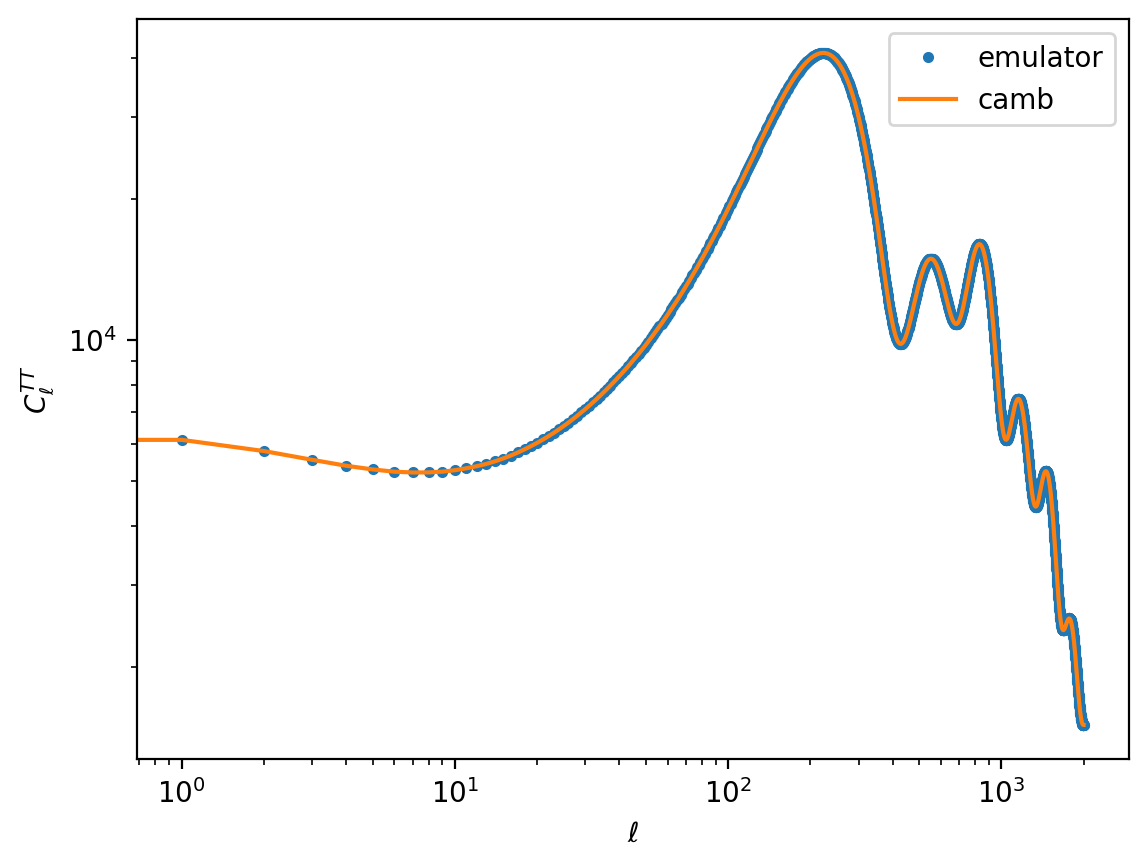

In [74]:
#Plot out one example to compare the difference between emulator and camb

ell=np.arange(2,2002,1)
plt.plot(testing_results[100]*ell*(ell+1),'.',label='emulator')
plt.plot(testing_data_vectors[100]*ell*(ell+1),label='camb')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}^{TT}$')
plt.legend()


**MCMC example**

In [75]:
fid=np.load('Demo/fid_demo.npy',allow_pickle=True)

def loglikelihood(omb):
    y=predict(torch.Tensor(np.array([omb])).to(device))[0]
    diff=fid-y
    return -0.5*diff@covinv@diff.T

In [76]:
predict(0.1)[0]-fid

array([-2.72492922e+02, -1.13606674e+02, -6.15253873e+01, ...,
        4.78962146e-04,  4.87202398e-04,  4.73802616e-04])

In [82]:
loglikelihood(0.0239)

-0.18439283888044417

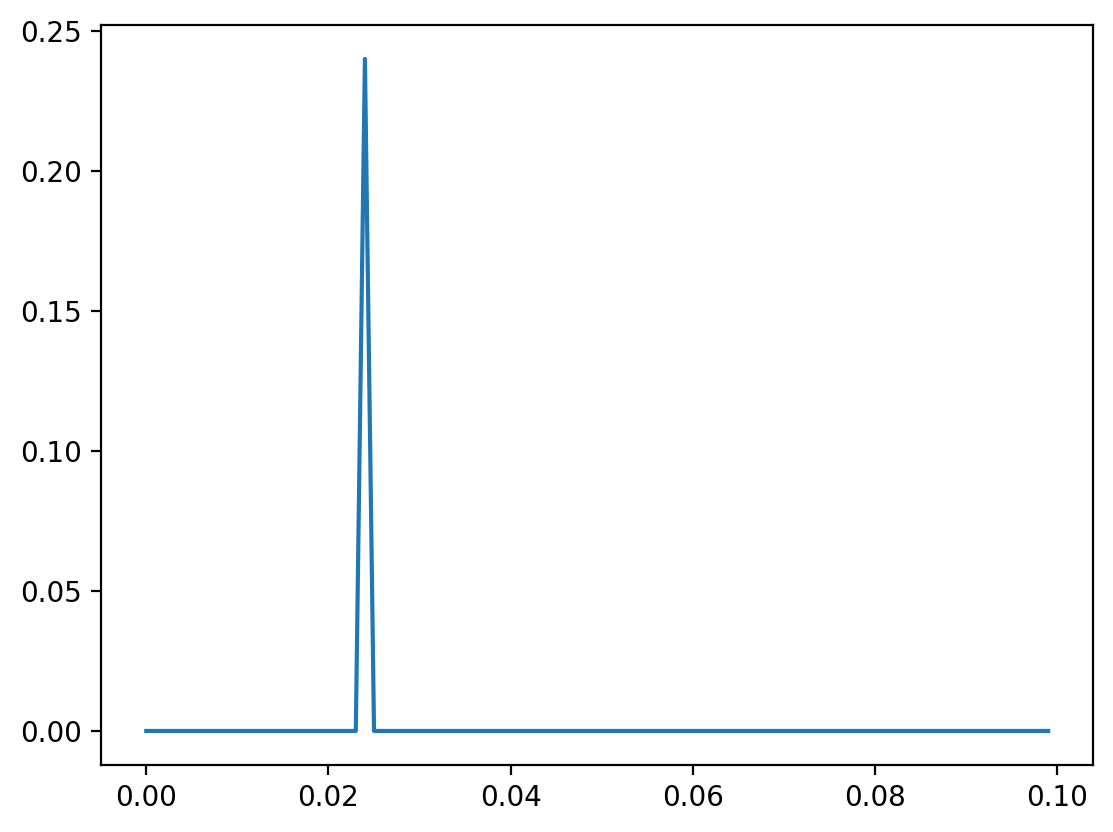

In [78]:
om=np.arange(0,0.1,0.001)
chi=[]
for x in om:
    chi.append(loglikelihood(x))
chi=np.array(chi)
plt.plot(om,np.exp(chi))

In [79]:
info = {
    "likelihood": {"banana": loglikelihood},
    "params": dict([
        ("omb", {
            "prior": {"min": 0, "max": 0.1},
            "latex": r"\Omega_b"})]),
    
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}}

In [80]:
from getdist.gaussian_mixtures import GaussianND
from getdist import plots, MCSamples

import getdist

from cobaya.run import run


from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

In [81]:
from cobaya.run import run

updated_info, sampler = run(info)

[banana] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {banana: 195.0}
[mcmc] Initial point: omb:0.09452281
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-09-18 14:21:56 : 1 steps taken, and 0 accepted.


AttributeError: 'MCMC' object has no attribute '_prior_tries_warning'